- check text data again and cleaning
- USE BERT, SOTA model 


In [117]:
import pandas as pd
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

In [118]:
!nvidia-smi

Fri Jul 10 03:41:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    71W / 149W |  10790MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [119]:
tweet= pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission = pd.read_csv("sample_submission.csv")

In [120]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [121]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [122]:
# check class distribution
Real_len = tweet[tweet['target']==1].shape[0]
Not_len = tweet[tweet['target']==0].shape[0]

In [123]:
print(Real_len, Not_len)

3271 4342


In [124]:
# check length of the text
## function to check 
def length(text):
  return len(text)

In [125]:
# add length column to the data
tweet['length'] = tweet['text'].apply(length)

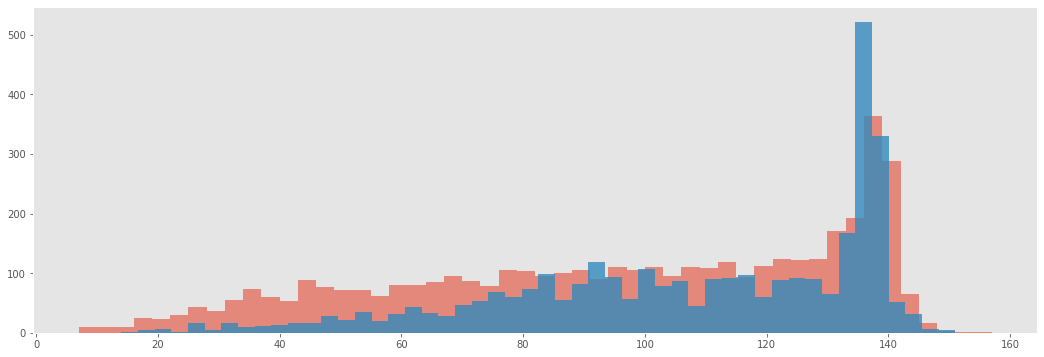

In [126]:
# check the length
# disaster red, not disaster blue 
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 50

plt.hist(tweet[tweet['target']==0]['length'], alpha=0.6, bins = bins, label='Not')
plt.hist(tweet[tweet['target']==1]['length'], alpha=0.8, bins = bins, label='Real')
plt.grid()
plt.show()

In [127]:
# create corpus
def create_corpus(target):
  corpus = []
  for x in tweet[tweet['target'] == target]['text'].str.split():
    for i in x:
      corpus.append(i)
  return corpus

In [128]:
# create corpus df
def create_corpus_df(tweet, target):
  corpus = []
  for x in tweet[tweet['target'] == target]['text'].str.split():
    for i in x:
      corpus.append(i)
  return corpus

stop words : tweets with class 0

In [129]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [130]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [131]:
corpus = create_corpus(0)

In [132]:
dic = defaultdict(int)

for word in corpus :
  if word in stop:
    dic[word] += 1

In [133]:
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

In [134]:
np.array(stop) # 해당 텍스트에 있는 불용어 제거 

array({'will', 'don', 'herself', 'whom', 'the', 'it', 'yours', "shan't", "should've", "you'll", 'isn', 'now', 'very', 'with', 'wouldn', 'mustn', 'ourselves', 'or', 'does', 'do', 'such', 'he', 'himself', 'in', 'after', 'each', 'wasn', 'ours', 'further', 'hadn', 'was', 'over', 'during', 'll', 'while', 'you', 'because', 've', 'doesn', 'as', "hadn't", 'o', 'shan', "hasn't", 'aren', 'but', 'be', "it's", 'off', "she's", 'when', 'both', 'did', "mightn't", "doesn't", "won't", 'couldn', 'ma', 'and', 'some', 'on', "needn't", 'she', 'again', 'what', 'how', 're', 'by', 'just', 'of', 'been', 'there', 'about', 'their', 'didn', 'they', "you're", 'that', 'under', 'yourself', "that'll", "wouldn't", 'more', 'who', "didn't", 'his', 's', 'i', 't', 'm', "weren't", "you'd", 'itself', 'down', "don't", 'd', "haven't", 'between', 'against', 'is', 'hers', 'have', 'before', 'won', 'myself', 'we', 'haven', 'same', "isn't", 'weren', 'until', 'an', 'were', 'theirs', 'nor', 'has', 'to', 'most', "shouldn't", 'them', 

stop words : tweets with class 1

In [135]:
corpus = create_corpus(1)

In [136]:
dic = defaultdict(int)

for word in corpus:
  if word in stop:
    dic[word] += 1

In [137]:
top = sorted(dic.items(), key = lambda x:x[1], reverse = True)[:10]

<BarContainer object of 10 artists>

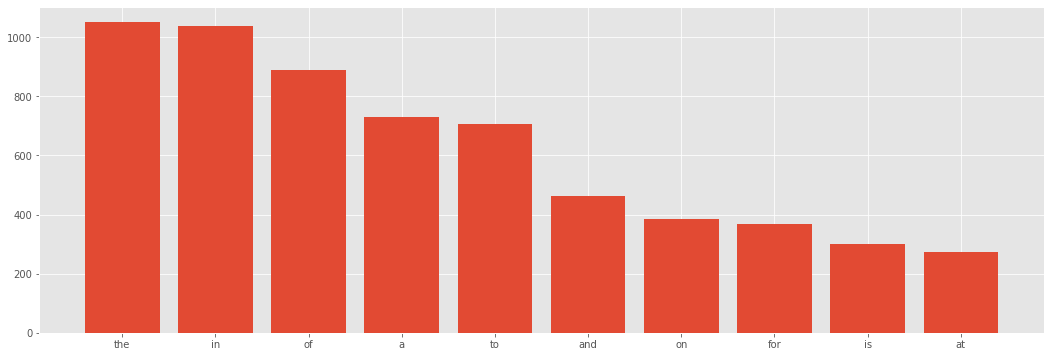

In [138]:
plt.rcParams['figure.figsize'] = (18, 6)
x,y = zip(*top)
plt.bar(x,y)

N-gram ( bigrams )

In [139]:
def get_top_tweet_bigrams(corpus, n=None) :
  vec = CountVectorizer(ngram_range= (2,2)).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis = 0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq = sorted(words_freq, key = lambda x:x[1], reverse = True)
  
  return words_freq[:n]

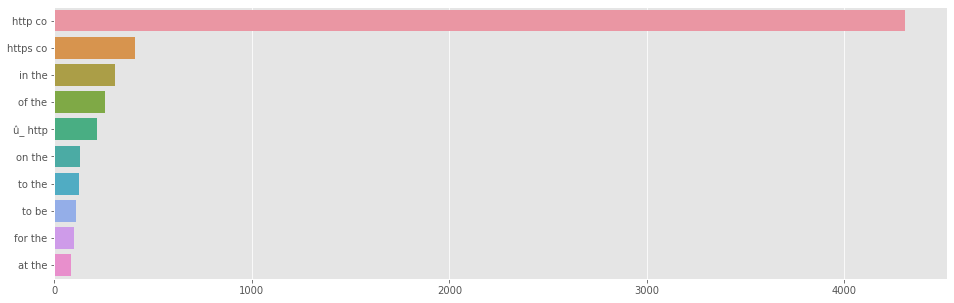

In [140]:
plt.figure(figsize = (16,5))
top_tweet_bigrams = get_top_tweet_bigrams(tweet['text'])[:10]
x,y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x)

elimination of stop words

In [141]:
df = pd.concat([tweet, test])

In [142]:
df.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,69.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,38.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,133.0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,65.0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,88.0


1. remove url

In [143]:
def remove_url(text):
  url = re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'', text)

In [144]:
df['text'] = df['text'].apply(lambda x : remove_url(x))

2. remove HTML tags

In [145]:
def remove_html(text):
  html = re.compile(r'<.*?>')
  return html.sub(r'', text)

In [146]:
df['text'] = df['text'].apply(lambda x : remove_html(x))

3. removing emojis

In [147]:
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [148]:
df['text']=df['text'].apply(lambda x: remove_emoji(x))

4. removing punctuation

In [149]:
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

In [150]:
df['text']=df['text'].apply(lambda x : remove_punct(x))

Bag of words counts

In [151]:
def cv(data):
  count_vectorizer = CountVectorizer()
  emb = count_vectorizer.fit_transform(data)
  
  return emb, count_vectorizer

In [152]:
list_corpus = df['text'].tolist()
list_labels = df['target'].tolist()

In [153]:
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size = 0.2)

In [154]:
X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

using model named BERT
- Load BERT from the tensorlow hub
- load tokenizer from the bert layer
- encode the txt into tokens, masks, and segment flags

In [155]:
# use the official tokenization script created by google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [156]:
!pip install sentencepiece

In [157]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import tokenization

In [158]:
# 논문에서 sentence의 정의가 512 token( max_len으로 지정한다. )
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [159]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    
    if Dropout_num == 0:
        # Without Dropout
        out = Dense(1, activation='sigmoid')(clf_output)
    else:
        # With Dropout(Dropout_num), Dropout_num > 0
        x = Dropout(Dropout_num)(clf_output)
        out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

- ref) https://www.kaggle.com/rftexas/text-only-bert-keras
- target correction

In [160]:
def clean_tweets(tweet):
    """Removes links and non-ASCII characters"""
    
    tweet = ''.join([x for x in tweet if x in string.printable])
    
    # Removing URLs
    tweet = re.sub(r"http\S+", "", tweet)
    
    return tweet

In [161]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [162]:
def remove_punctuations(text):
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    
    for p in punctuations:
        text = text.replace(p, f' {p} ')

    text = text.replace('...', ' ... ')
    
    if '...' not in text:
        text = text.replace('..', ' ... ')
    
    return text

In [163]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [164]:
def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

In [165]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [166]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [167]:
if False:
    ids_with_target_error = [328,443,513,2619,3640,3900,4342,5781,6552,6554,6570,6701,6702,6729,6861,7226]
    train.loc[train['id'].isin(ids_with_target_error),'target'] = 0
    train[train['id'].isin(ids_with_target_error)]

In [168]:
if False:
    train["text"] = train["text"].apply(lambda x: clean_tweets(x))
    test["text"] = test["text"].apply(lambda x: clean_tweets(x))
    
    train["text"] = train["text"].apply(lambda x: remove_emoji(x))
    test["text"] = test["text"].apply(lambda x: remove_emoji(x))
    
    train["text"] = train["text"].apply(lambda x: remove_punctuations(x))
    test["text"] = test["text"].apply(lambda x: remove_punctuations(x))
    
    train["text"] = train["text"].apply(lambda x: convert_abbrev_in_text(x))
    test["text"] = test["text"].apply(lambda x: convert_abbrev_in_text(x))

In [169]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [170]:
# txt를 token, mask, segment flag로 인코딩
train_input = bert_encode(train.text.values, tokenizer, max_len=160)
test_input = bert_encode(test.text.values, tokenizer, max_len=160)
train_labels = train.target.values

In [171]:
Dropout_num = 0
learning_rate = 6e-6
valid = 0.2
epochs_num = 3
batch_size_num = 16

In [172]:
model_BERT = build_model(bert_layer, max_len=160)
model_BERT.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [174]:
# train
checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)

train_history = model_BERT.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint],
    batch_size=1
)

Epoch 1/3
6090/6090 [==============================] - 2584s 424ms/step - loss: 0.4330 - accuracy: 0.8146 - val_loss: 0.4241 - val_accuracy: 0.8109
Epoch 2/3
6090/6090 [==============================] - 2492s 409ms/step - loss: 0.2849 - accuracy: 0.8887 - val_loss: 0.4560 - val_accuracy: 0.8339
Epoch 3/3
6090/6090 [==============================] - 2491s 409ms/step - loss: 0.1560 - accuracy: 0.9445 - val_loss: 0.5782 - val_accuracy: 0.8188


submit

In [176]:
# Prediction by BERT model with my tuning
model_BERT.load_weights('model.h5')
test_pred_BERT = model_BERT.predict(test_input)
test_pred_BERT_int = test_pred_BERT.round().astype('int')

In [177]:
train_pred_BERT = model_BERT.predict(train_input)
train_pred_BERT_int = train_pred_BERT.round().astype('int')

In [178]:
pred = pd.DataFrame(test_pred_BERT, columns=['preds'])

In [179]:
submission['target'] = test_pred_BERT_int
submission.head(10) # check 

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0


In [180]:
submission.to_csv("submission2.csv", index=False, header=True)